# Imports

In [26]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
EMG_DIR = os.path.join(DATA_DIR, "EMG")
OUT_DIR = os.path.join(PROJECT_ROOT, "output")

EMG_OUTPUT_DIR = os.path.join(OUT_DIR, "emg")
os.makedirs(EMG_OUTPUT_DIR, exist_ok=True)

# Part 1: Single subject classification

## Loading data

In [2]:
s2_dir = Path(EMG_DIR) / 's2'

mat_files = sorted(s2_dir.glob('S2_*.mat'))
print(f'found {len(mat_files)} .mat files for subject 2')
for f in mat_files:
    m = loadmat(f, squeeze_me=True)
    keys = [k for k in m.keys() if not k.startswith('__')]
    print(f'\n{f.name}: keys -> {keys}')
    emg_key = next((k for k in keys if 'emg' in k.lower()), None)
    if emg_key:
        emg = m[emg_key]
        print(f'  {emg_key} shape: {np.shape(emg)}')
    restimulus = m.get('restimulus', None)
    if restimulus is not None:
        rs = np.asarray(restimulus).ravel()
        print(f'  unique stimulus labels: {np.unique(rs)}')
    rerepetition = m.get('rerepetition', None)
    if rerepetition is not None:
        rr = np.asarray(rerepetition).ravel()
        print(f'  repetitions: {np.unique(rr)}')

# Save only exercise 1 for subject 2
s2_dir = Path(EMG_DIR) / 's2'
ex1_file = sorted(s2_dir.glob('S2_A1_E1.mat'))
if not ex1_file:
    raise FileNotFoundError('S2_A1_E1.mat not found under EMG_DIR/s2')
ex1_path = ex1_file[0]
mat_ex1 = loadmat(ex1_path, squeeze_me=True)

subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
emg_ex1 = np.asarray(mat_ex1['emg'])
glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
fs_val = mat_ex1.get('fs', None)
fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0

out_path = s2_dir / 's2_ex1_raw.npz'
np.savez(
    out_path,
    subject=subject,
    exercise=exercise,
    stimulus=stimulus,
    restimulus=restimulus,
    repetition=repetition,
    rerepetition=rerepetition,
    emg=emg_ex1,
    glove=glove,
    fs=fs_ex1,
)
print(f'\nsaved exercise 1 to {out_path}')

found 3 .mat files for subject 2

S2_A1_E1.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (100686, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E2.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (142731, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E3.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (229084, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s2/s2_ex1_raw.npz


### Visualize data before processing

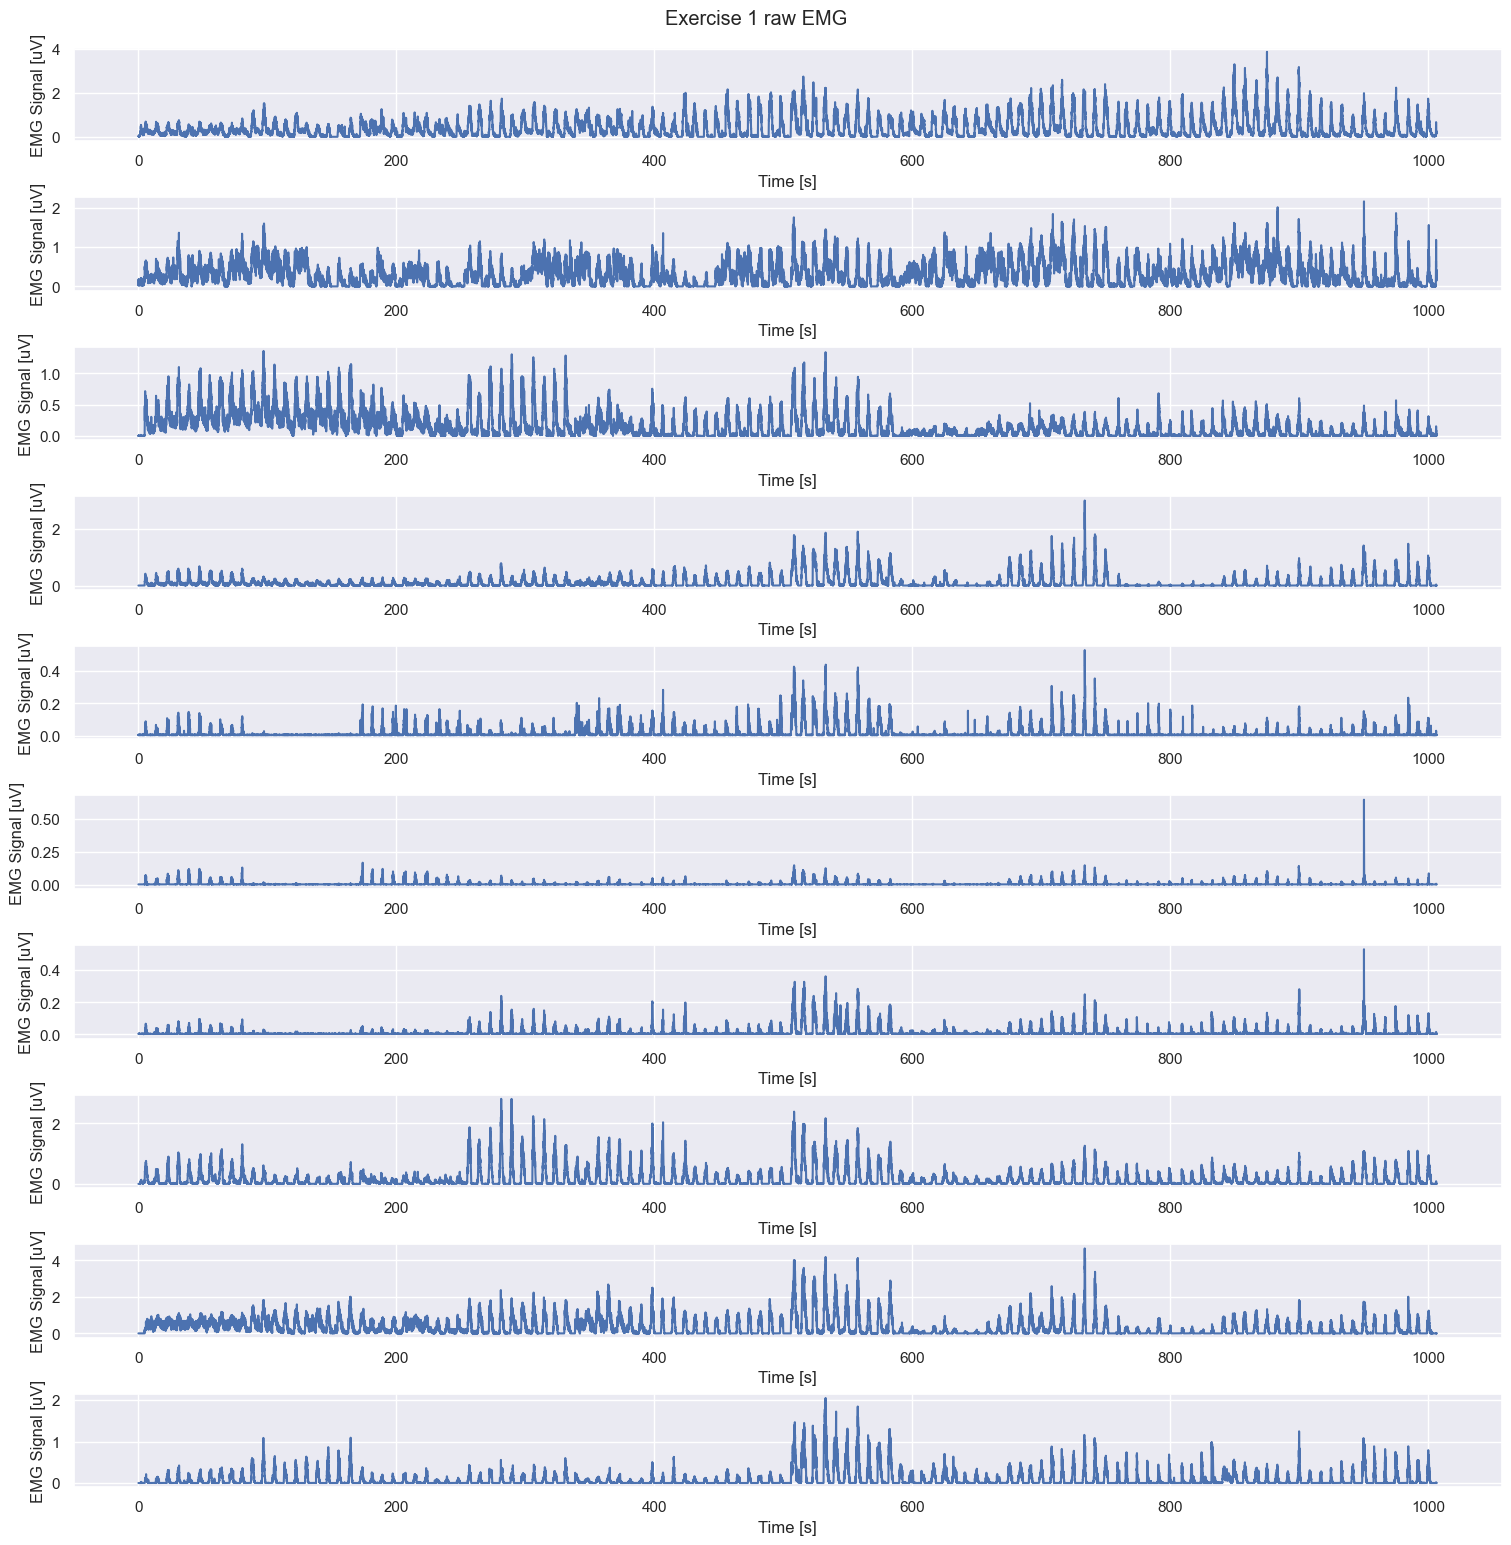

In [3]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg_raw = raw['emg']
fs = float(raw['fs'])
n_channels = emg_raw.shape[1]
time_steps = np.arange(emg_raw.shape[0]) / fs

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


## Preprocessing

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

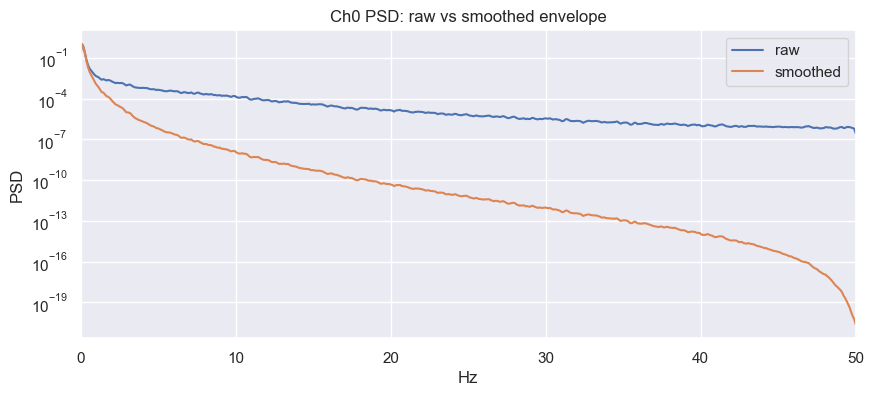

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s2/s2_ex1_processed.npz


In [4]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg = raw['emg']
fs = float(raw['fs'])  # This is 100.0
n_channels = emg.shape[1]
time_steps = np.arange(emg.shape[0]) / fs

# plot PSD of raw vs smoothed on one plot
f_raw, pxx_raw = welch(emg[:, 0], fs=fs, nperseg=1024)

sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
emg_filtered = sosfiltfilt(sos, emg.T).T
f_filt, pxx_filt = welch(emg_filtered[:, 0], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, pxx_raw, label='raw')
plt.semilogy(f_filt, pxx_filt, label='smoothed')
plt.xlim(0, 50)
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.title('Ch0 PSD: raw vs smoothed envelope')
plt.grid(True)
plt.legend()
plt.show()

# 4. Save
band_out = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
os.makedirs(Path(EMG_OUTPUT_DIR) / 's2', exist_ok=True)
np.savez(
    band_out,
    emg=emg_filtered,
    subject=raw.get('subject'),
    exercise=raw.get('exercise'),
    stimulus=raw.get('stimulus'),
    restimulus=raw.get('restimulus'),
    repetition=raw.get('repetition'),
    rerepetition=raw.get('rerepetition'),
    glove=raw.get('glove'),
    fs=fs,
)
print(f'Processed data saved to {band_out}')

In [5]:
data = np.load(band_out) # using the file you just saved
stimulus = data['stimulus'] 
restimulus = raw['restimulus']
repetition = data['repetition']

# Get list of movements (excluding 0/rest)
movements = np.unique(stimulus)
movements = movements[movements != 0]

print(f"Checking Subject 2 trials (Target: 10 reps per movement)...")
missing_trials = []

for mov in movements:
    # Find which reps exist for this movement in the CORRECTED labels
    # We look at where restimulus == mov, and get the unique repetition numbers there
    actual_reps = np.unique(repetition[restimulus == mov])
    
    # We expect reps 1 through 10
    expected_reps = np.arange(1, 11)
    
    # Check if any are missing
    missing = np.setdiff1d(expected_reps, actual_reps)
    
    if len(missing) > 0:
        print(f"  Movement {mov}: Missing reps {missing}")
        missing_trials.append((mov, missing))
    else:
        # Optional: Print success to be sure
        pass 

if not missing_trials:
    print("\nSUCCESS: All trials are present in the corrected data.")
else:
    print("\nWARNING: Some trials were removed by the relabeling algorithm.")

Checking Subject 2 trials (Target: 10 reps per movement)...

SUCCESS: All trials are present in the corrected data.


# Part 2: Generalization across subjects

## Preprocessing data

In [25]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    s_num_uppercase = 'S' + str(i)
    s_dir = Path(EMG_DIR) / s_num_lowercase
    
    mat_files = sorted(s_dir.glob(s_num_uppercase + '_*.mat'))
    print(f'found {len(mat_files)} .mat files for subject', s_num_lowercase)
    for f in mat_files:
        m = loadmat(f, squeeze_me=True)
        keys = [k for k in m.keys() if not k.startswith('__')]
        emg_key = next((k for k in keys if 'emg' in k.lower()), None)
        if emg_key:
            emg = m[emg_key]
        restimulus = m.get('restimulus', None)
        if restimulus is not None:
            rs = np.asarray(restimulus).ravel()
        rerepetition = m.get('rerepetition', None)
        if rerepetition is not None:
            rr = np.asarray(rerepetition).ravel()
    
    # Save only exercise 1 for subject x
    ex1_file = sorted(s_dir.glob(s_num_uppercase + '_A1_E1.mat'))
    if not ex1_file:
        raise FileNotFoundError(s_num_uppercase + '_A1_E1.mat not found under EMG_DIR/' + s_num_lowercase)
    ex1_path = ex1_file[0]
    mat_ex1 = loadmat(ex1_path, squeeze_me=True)

    subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
    exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
    stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
    restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
    repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
    rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
    emg_ex1 = np.asarray(mat_ex1['emg'])
    glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
    fs_val = mat_ex1.get('fs', None)
    fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0
    
    out_path = s_dir / (s_num_lowercase + '_ex1_raw.npz')
    np.savez(
        out_path,
        subject=subject,
        exercise=exercise,
        stimulus=stimulus,
        restimulus=restimulus,
        repetition=repetition,
        rerepetition=rerepetition,
        emg=emg_ex1,
        glove=glove,
        fs=fs_ex1,
    )
    print(f'\nsaved exercise 1 to {out_path}')

found 3 .mat files for subject s1

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s1/s1_ex1_raw.npz
found 3 .mat files for subject s2

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s2/s2_ex1_raw.npz
found 3 .mat files for subject s3

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s3/s3_ex1_raw.npz
found 3 .mat files for subject s4

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s4/s4_ex1_raw.npz
found 3 .mat files for subject s5

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s5/s5_ex1_raw.npz
found 3 .mat files for subject s6

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s6/s6_ex1_raw.npz
found 3 .mat files for subject s7

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s7/s7_ex1_raw.npz
found 3 .mat files for subject s8

saved exercise 1 to /Users/baltin/Downloads/subjects/data/EMG/s8/s8_ex1_raw.npz
found 3 .mat files for subject s9

saved exercise 1 to /Users/baltin/Downloads/s

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

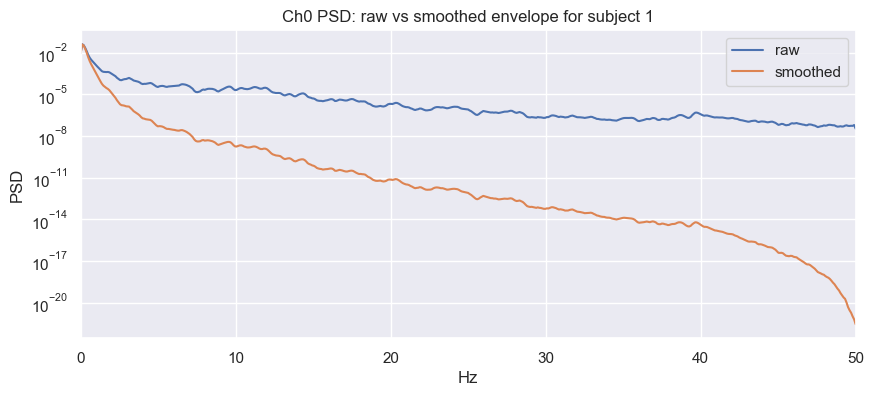

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s1/s1_ex1_processed.npz


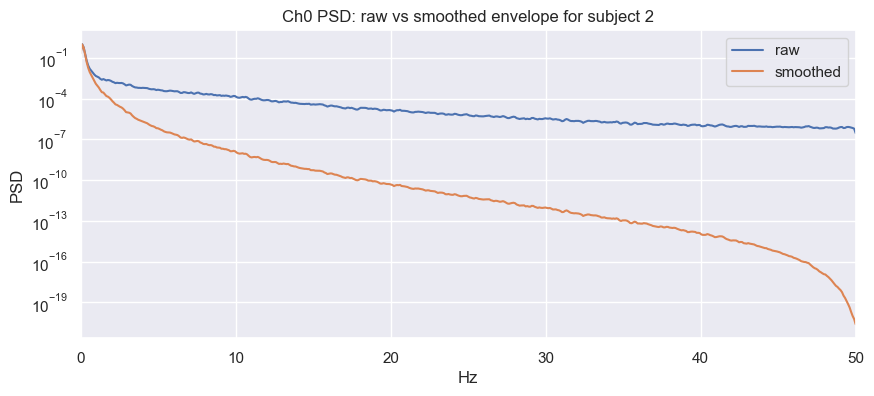

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s2/s2_ex1_processed.npz


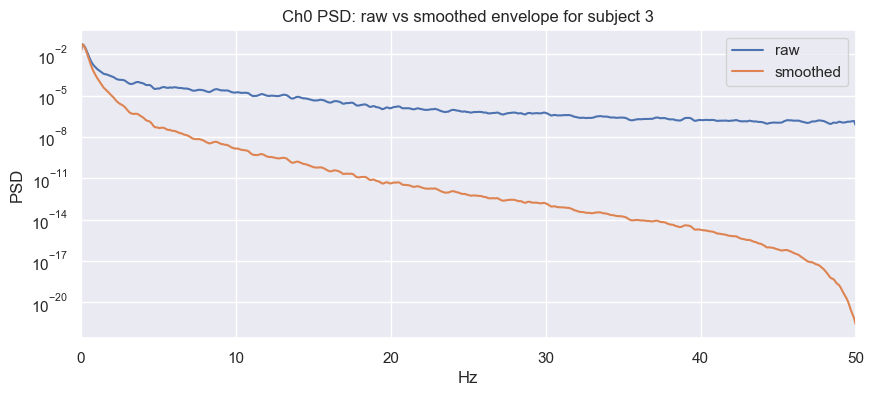

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s3/s3_ex1_processed.npz


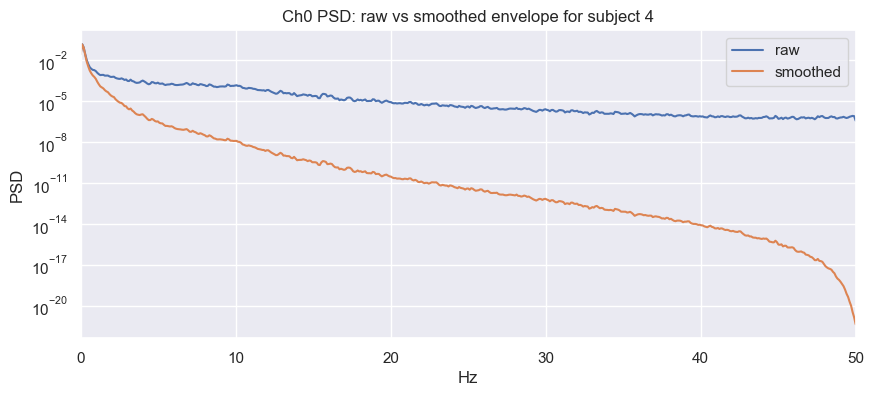

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s4/s4_ex1_processed.npz


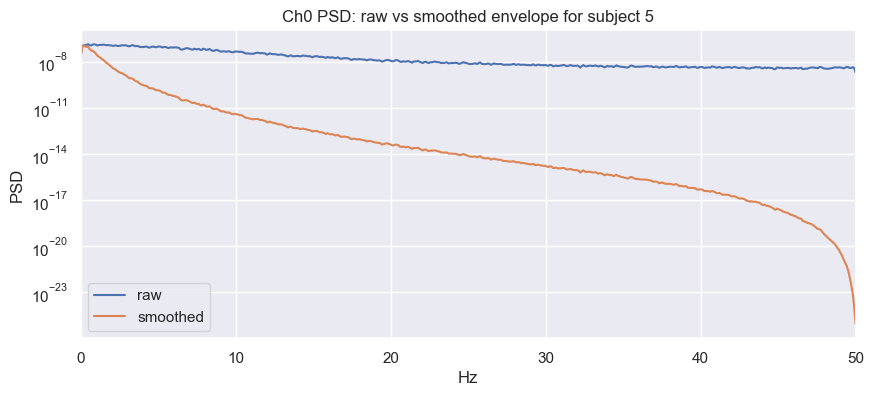

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s5/s5_ex1_processed.npz


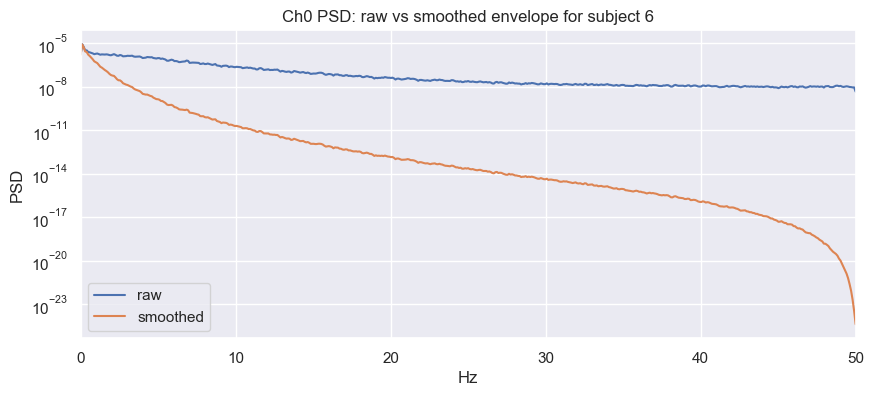

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s6/s6_ex1_processed.npz


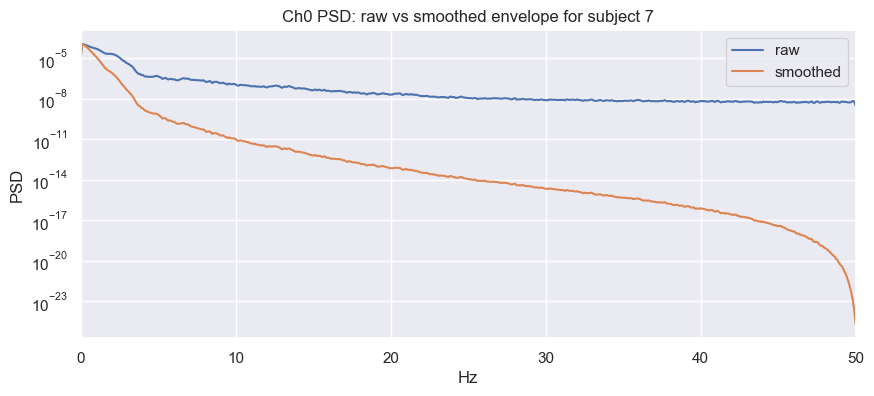

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s7/s7_ex1_processed.npz


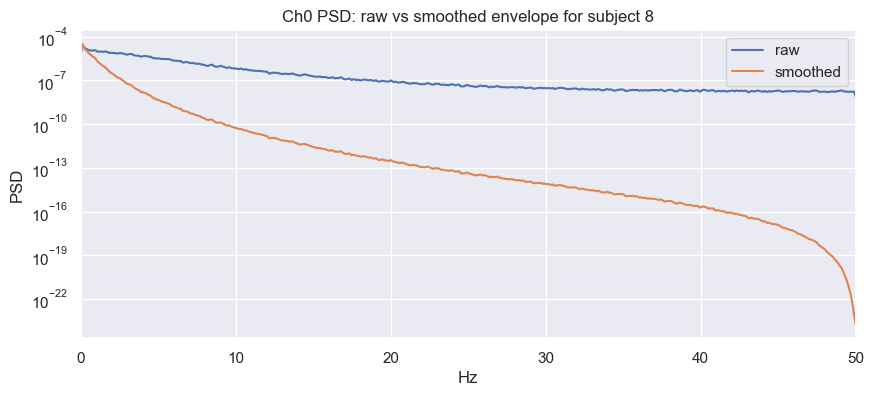

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s8/s8_ex1_processed.npz


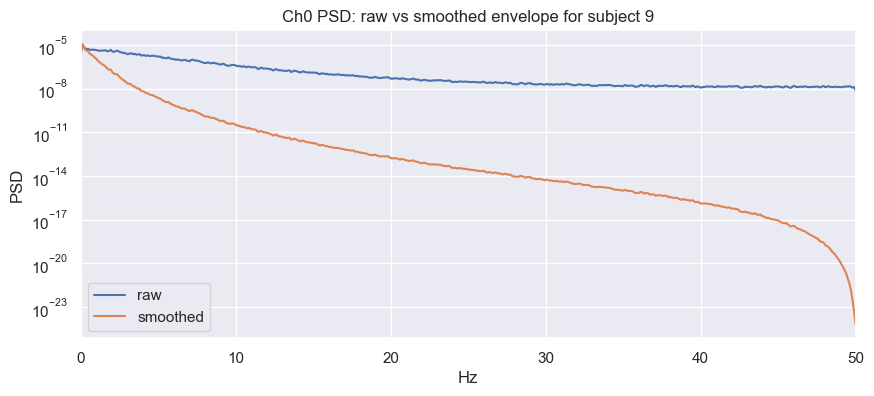

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s9/s9_ex1_processed.npz


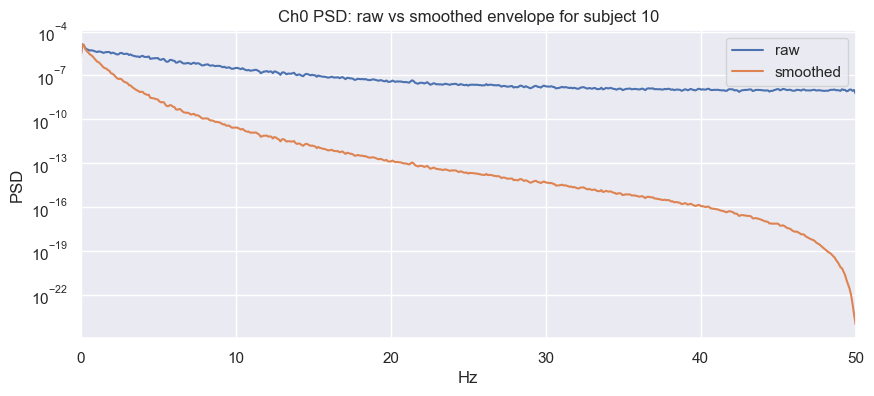

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s10/s10_ex1_processed.npz


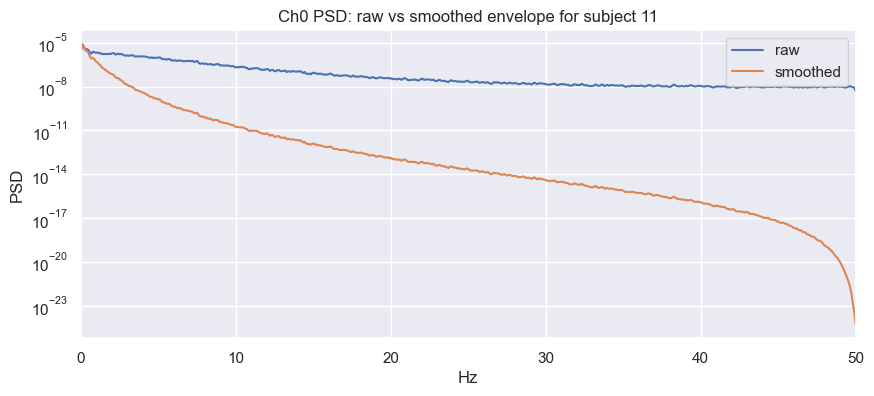

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s11/s11_ex1_processed.npz


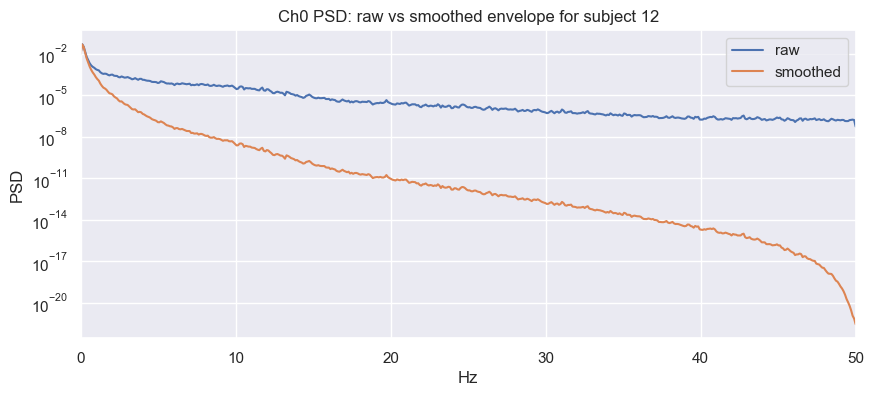

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s12/s12_ex1_processed.npz


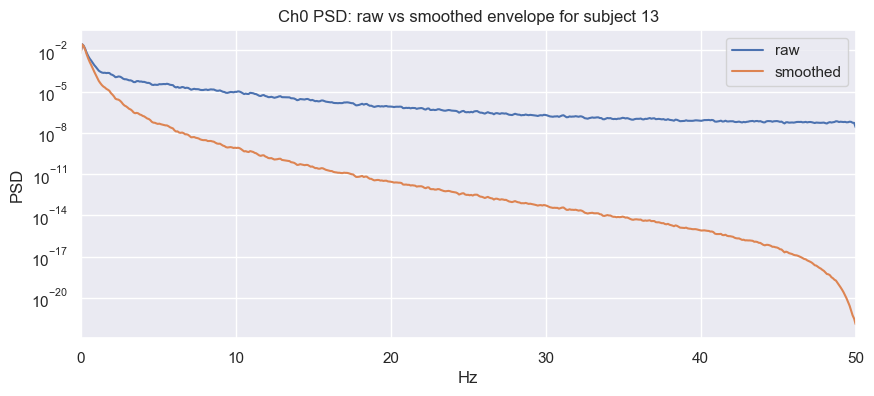

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s13/s13_ex1_processed.npz


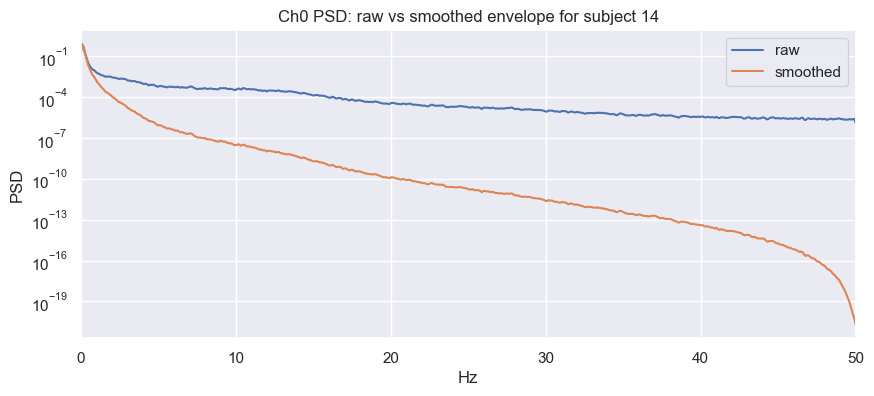

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s14/s14_ex1_processed.npz


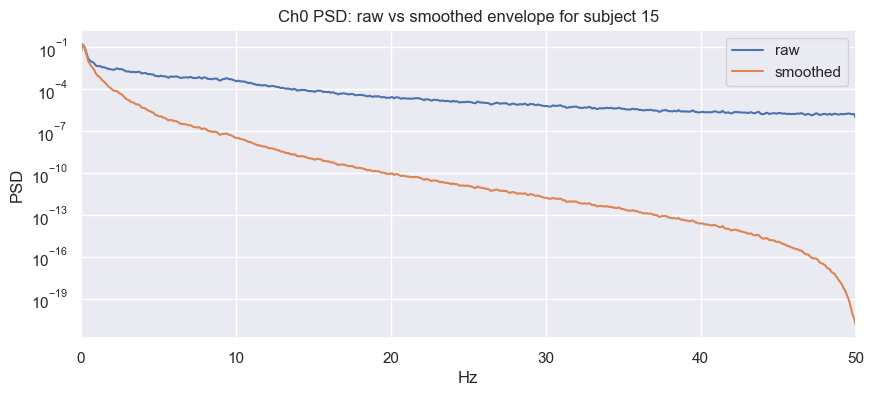

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s15/s15_ex1_processed.npz


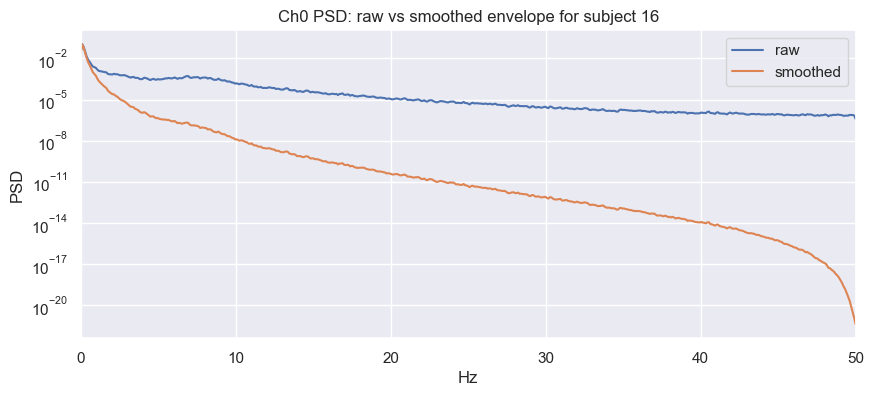

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s16/s16_ex1_processed.npz


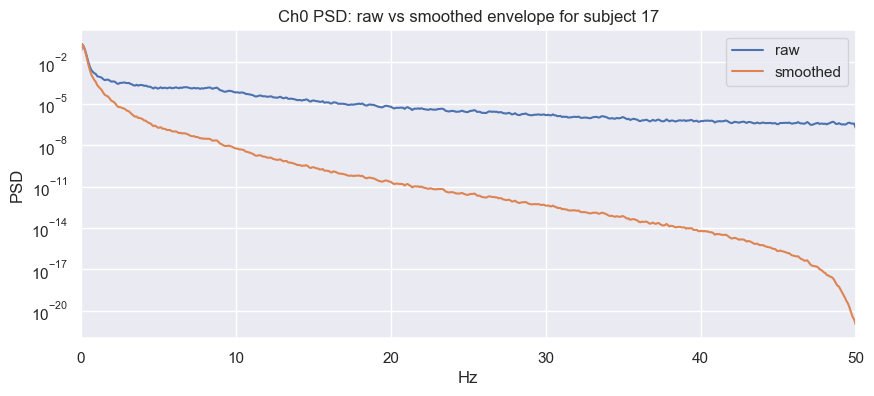

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s17/s17_ex1_processed.npz


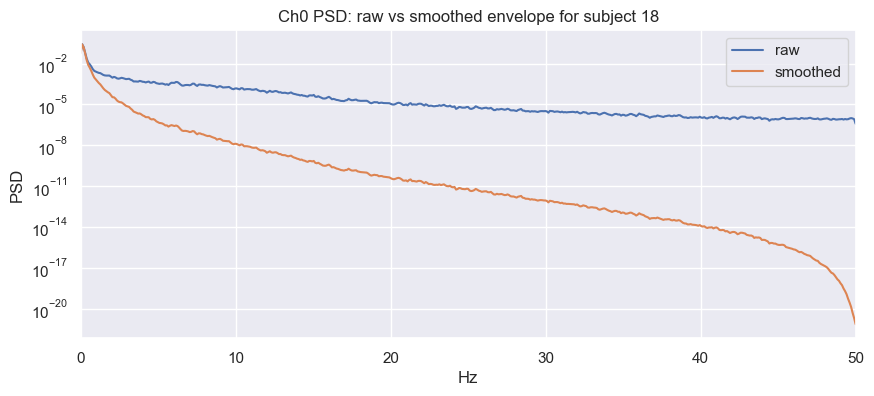

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s18/s18_ex1_processed.npz


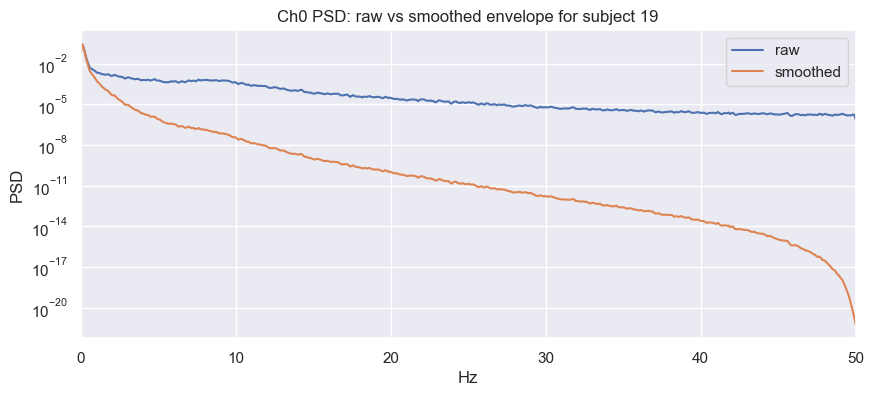

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s19/s19_ex1_processed.npz


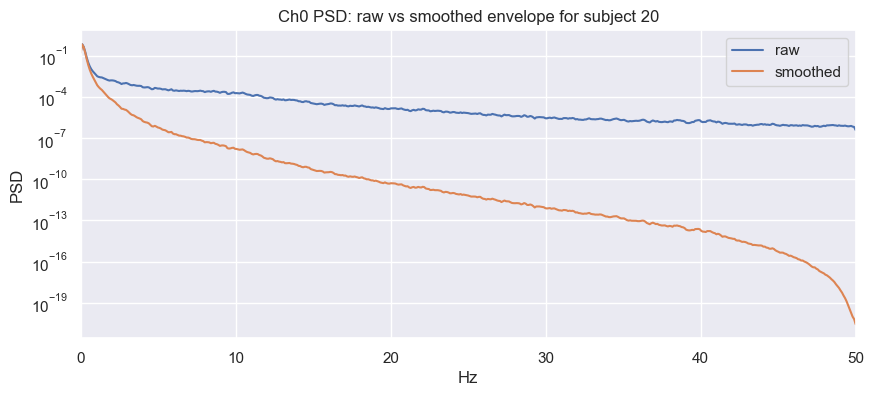

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s20/s20_ex1_processed.npz


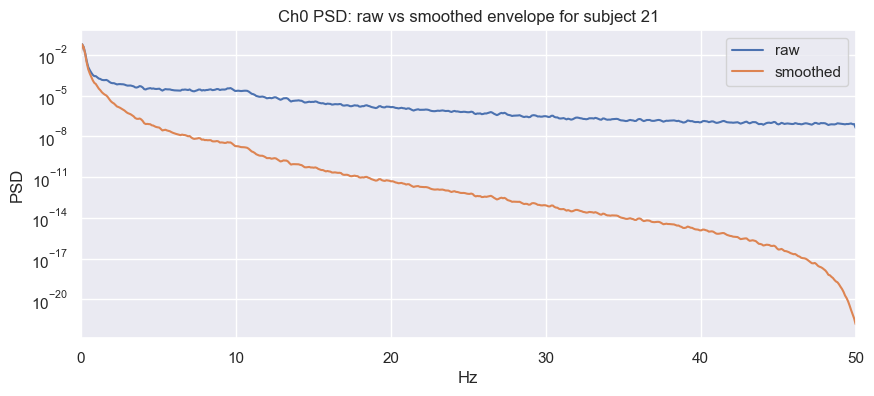

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s21/s21_ex1_processed.npz


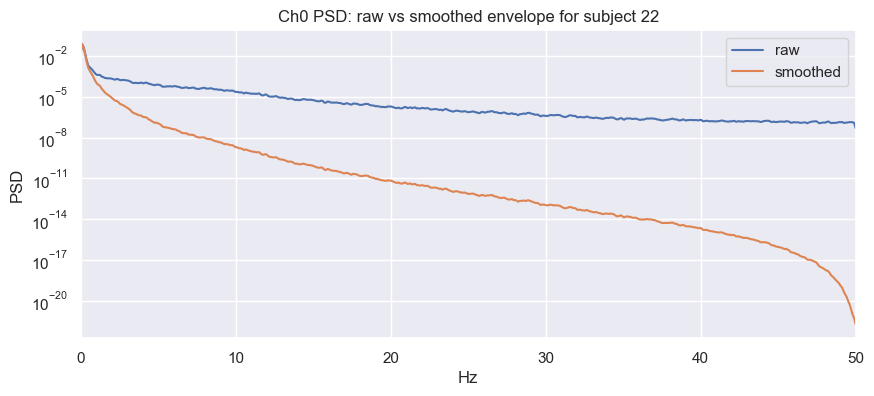

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s22/s22_ex1_processed.npz


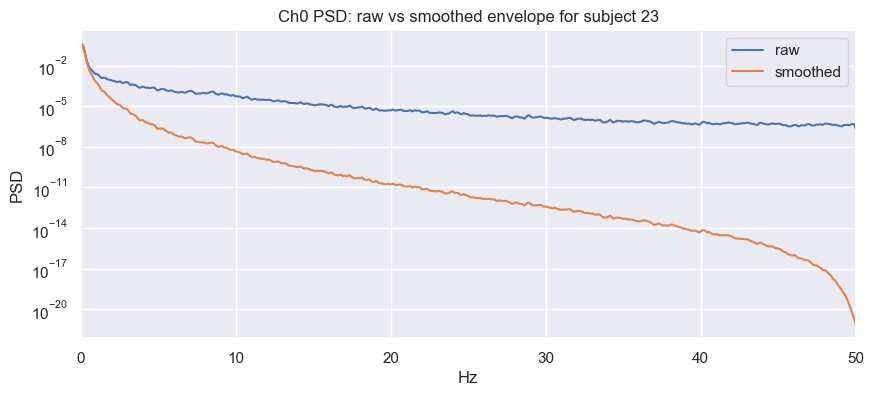

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s23/s23_ex1_processed.npz


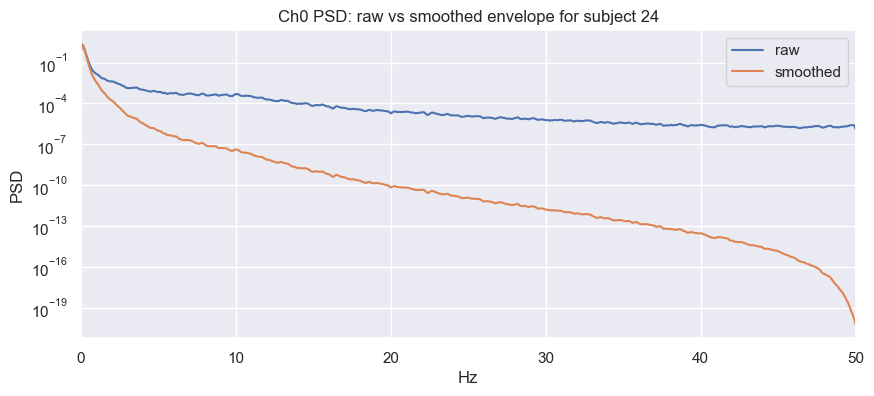

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s24/s24_ex1_processed.npz


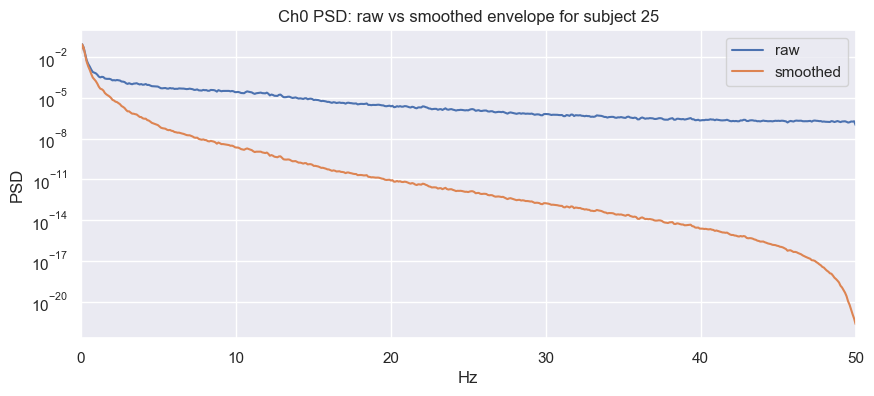

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s25/s25_ex1_processed.npz


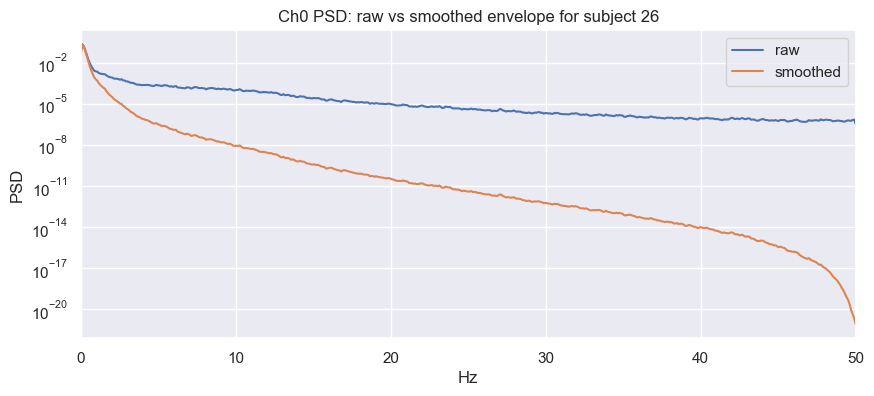

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s26/s26_ex1_processed.npz


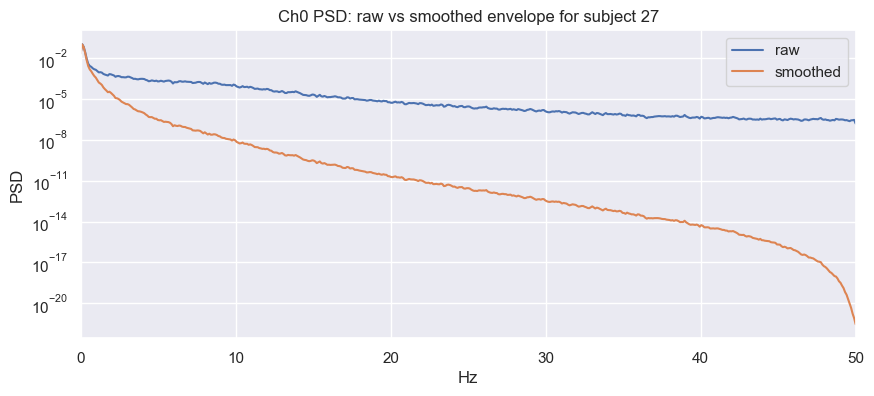

Processed data saved to /Users/baltin/Downloads/subjects/output/emg/s27/s27_ex1_processed.npz


In [39]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)

    s_a1_e1_path = Path(EMG_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_raw.npz')
    raw = np.load(s_a1_e1_path)
    emg = raw['emg']
    fs = float(raw['fs'])  # This is 100.0
    n_channels = emg.shape[1]
    time_steps = np.arange(emg.shape[0]) / fs
    
    # plot PSD of raw vs smoothed on one plot
    f_raw, pxx_raw = welch(emg[:, 0], fs=fs, nperseg=1024)
    
    sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
    emg_filtered = sosfiltfilt(sos, emg.T).T
    f_filt, pxx_filt = welch(emg_filtered[:, 0], fs=fs, nperseg=1024)
    
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_raw, pxx_raw, label='raw')
    plt.semilogy(f_filt, pxx_filt, label='smoothed')
    plt.xlim(0, 50)
    plt.xlabel('Hz')
    plt.ylabel('PSD')
    plt.title('Ch0 PSD: raw vs smoothed envelope for subject ' + str(i))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 4. Save
    band_out = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    os.makedirs(Path(EMG_OUTPUT_DIR) / s_num_lowercase, exist_ok=True)
    np.savez(
        band_out,
        emg=emg_filtered,
        subject=raw.get('subject'),
        exercise=raw.get('exercise'),
        stimulus=raw.get('stimulus'),
        restimulus=raw.get('restimulus'),
        repetition=raw.get('repetition'),
        rerepetition=raw.get('rerepetition'),
        glove=raw.get('glove'),
        fs=fs,
    )
    print(f'Processed data saved to {band_out}')

    

### Inspecting Bad Trials

In [34]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    
    input_path = Path(EMG_OUTPUT_DIR) /  s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    STRICT_MODE = False      
    DEAD_THRESHOLD = 1e-6    
    ARTIFACT_THRESHOLD = 5.0 
    
    if not input_path.exists():
        print(f"Error: File not found at {input_path}")
    else:
        data = np.load(input_path)
        emg = data['emg']
        restimulus = data['restimulus']   
        rerepetition = data['rerepetition']
        fs = data['fs']
    
        bad_trials_indices = []    
        movements = np.unique(restimulus)
        movements = movements[movements != 0]
    
        print("Scanning active trials for sensor faults...")
        for mov in movements:
            for rep in range(1, 11): 
                mask_indices = np.where((restimulus == mov) & (rerepetition == rep))[0]
                
                if len(mask_indices) == 0:
                    continue
                
                trial_data = emg[mask_indices]
                
                if np.all(np.std(trial_data, axis=0) < DEAD_THRESHOLD) or \
                   np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD:
                    
                    print(f"  Discarding Bad Trial: Mov {mov}, Rep {rep}")
                    bad_trials_indices.extend(mask_indices)
    
        keep_mask = (restimulus != 0)
        if len(bad_trials_indices) > 0:
            keep_mask[bad_trials_indices] = False
    
        emg_final = emg[keep_mask]
        restimulus_final = restimulus[keep_mask]
        rerepetition_final = rerepetition[keep_mask]
    
        print("-" * 30)
        print(f"Original shape: {emg.shape}")
        print(f"Final shape:    {emg_final.shape} (Rest & Bad Trials removed)")
    
        output_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_cleaned.npz')
        np.savez(output_path, 
                 emg=emg_final, 
                 restimulus=restimulus_final, 
                 rerepetition=rerepetition_final, 
                 fs=fs)
    
        print(f"Saved: {output_path}")

Scanning active trials for sensor faults...
------------------------------
Original shape: (101014, 10)
Final shape:    (37700, 10) (Rest & Bad Trials removed)
Saved: /Users/baltin/Downloads/subjects/output/emg/s1/s1_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Saved: /Users/baltin/Downloads/subjects/output/emg/s2/s2_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100720, 10)
Final shape:    (38274, 10) (Rest & Bad Trials removed)
Saved: /Users/baltin/Downloads/subjects/output/emg/s3/s3_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------------
Original shape: (100835, 10)
Final shape:    (46569, 10) (Rest & Bad Trials removed)
Saved: /Users/baltin/Downloads/subjects/output/emg/s4/s4_ex1_cleaned.npz
Scanning active trials for sensor faults...
------------------------

### Visualizing average activation maps

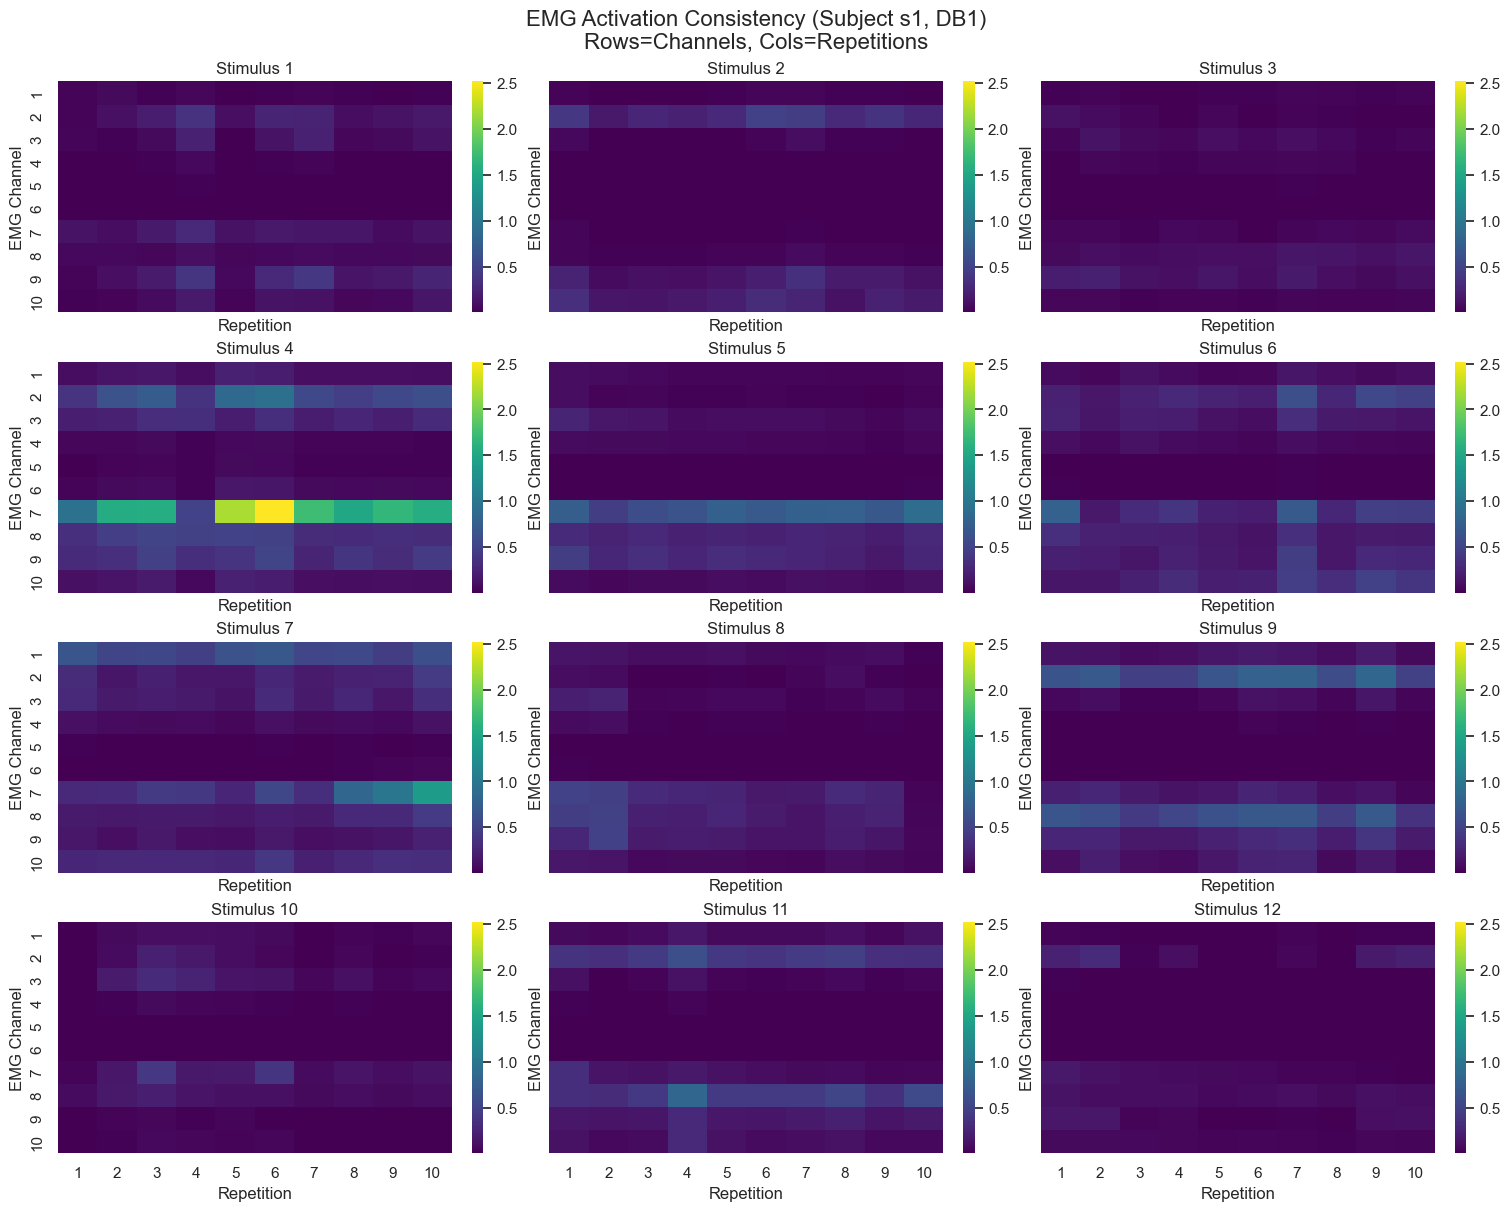

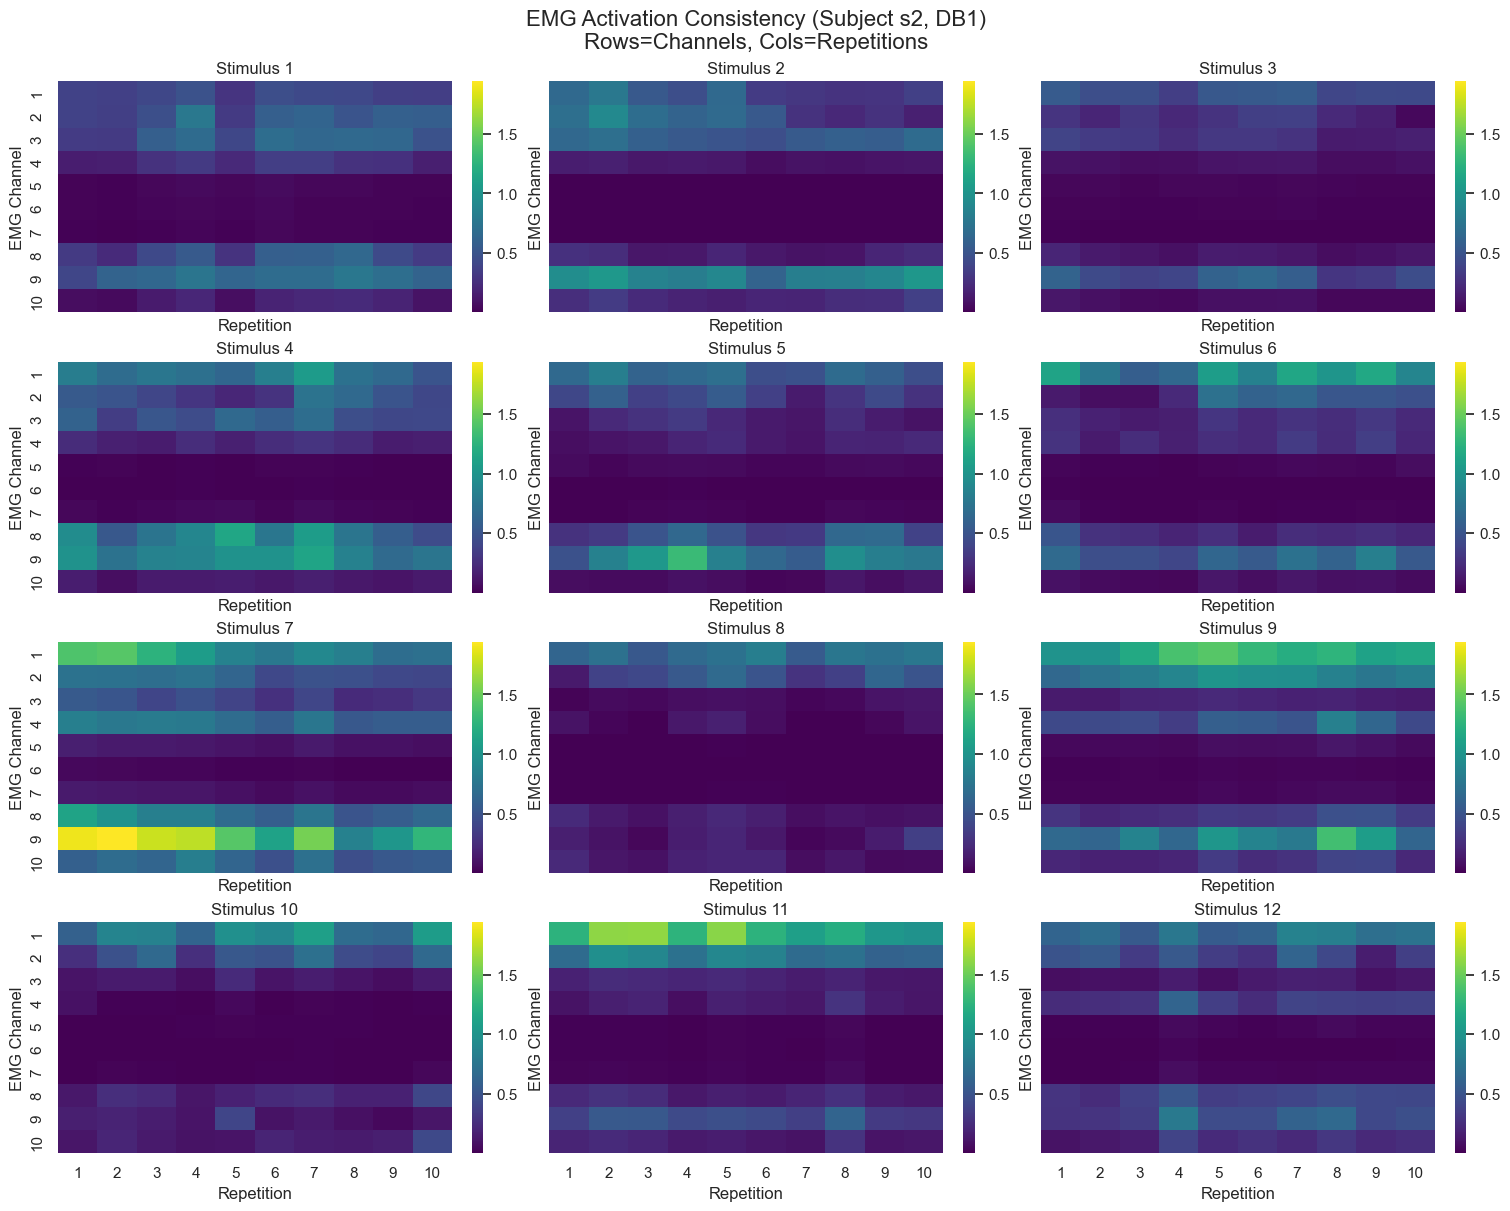

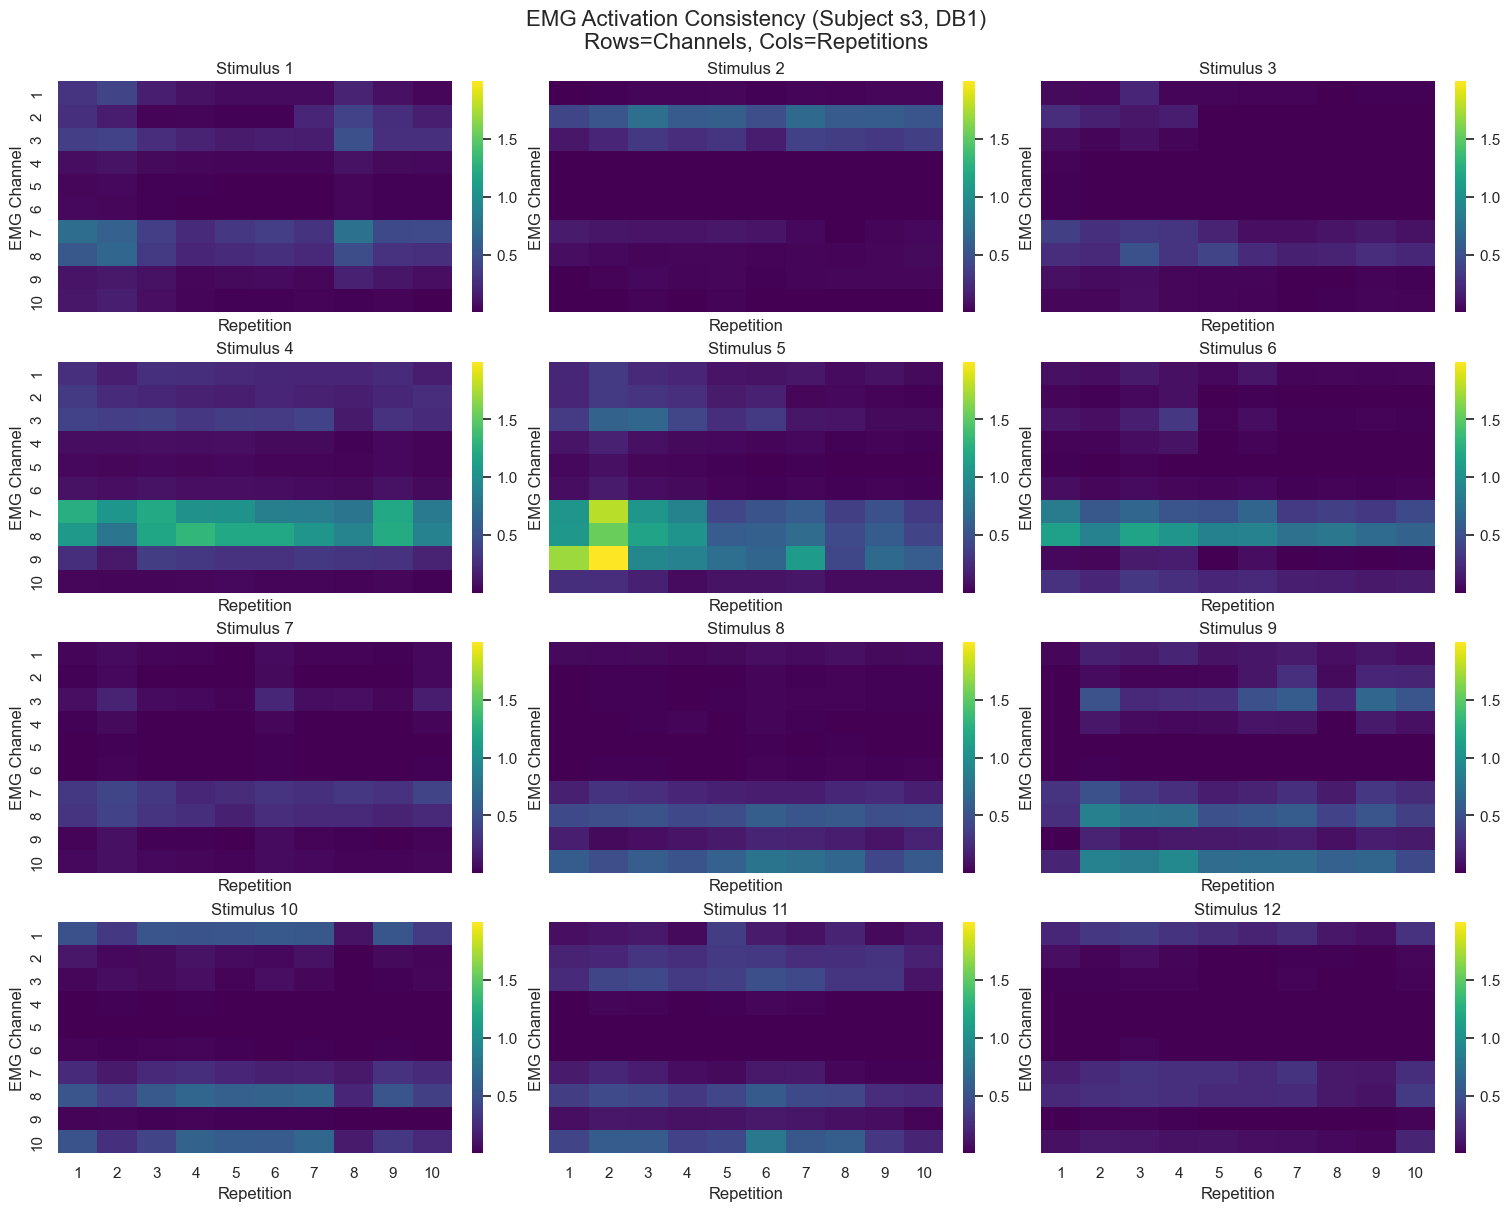

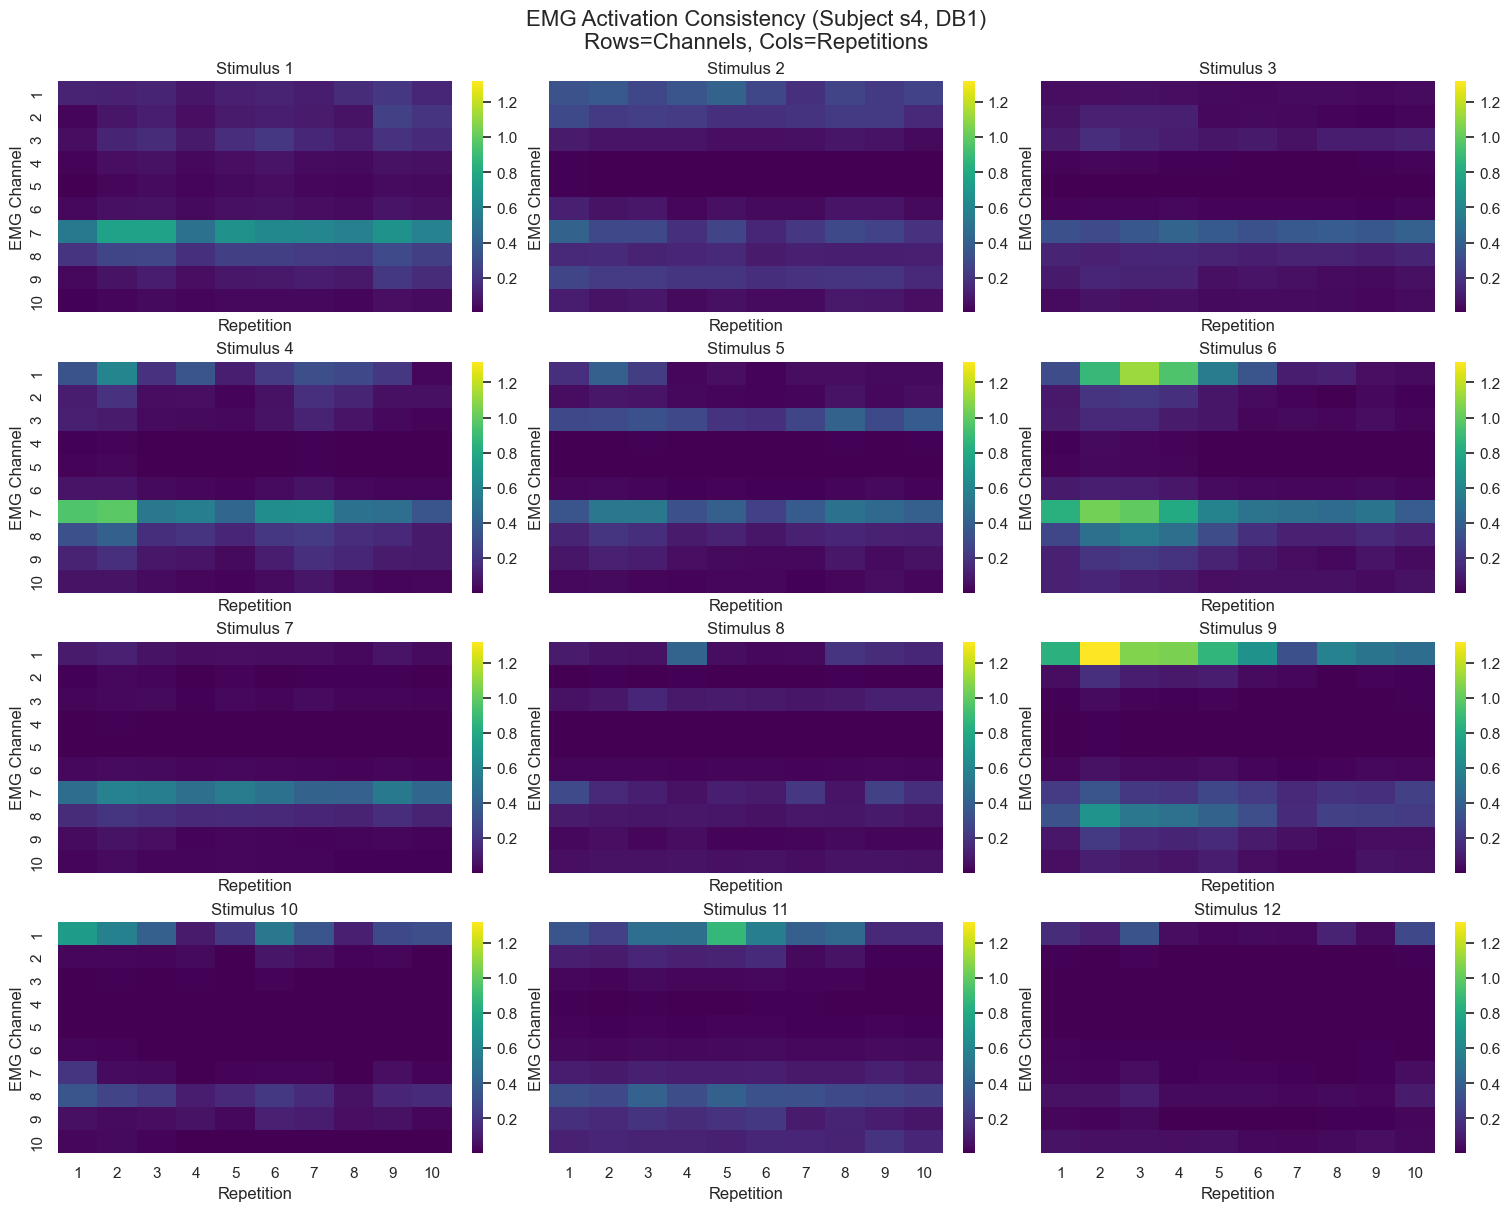

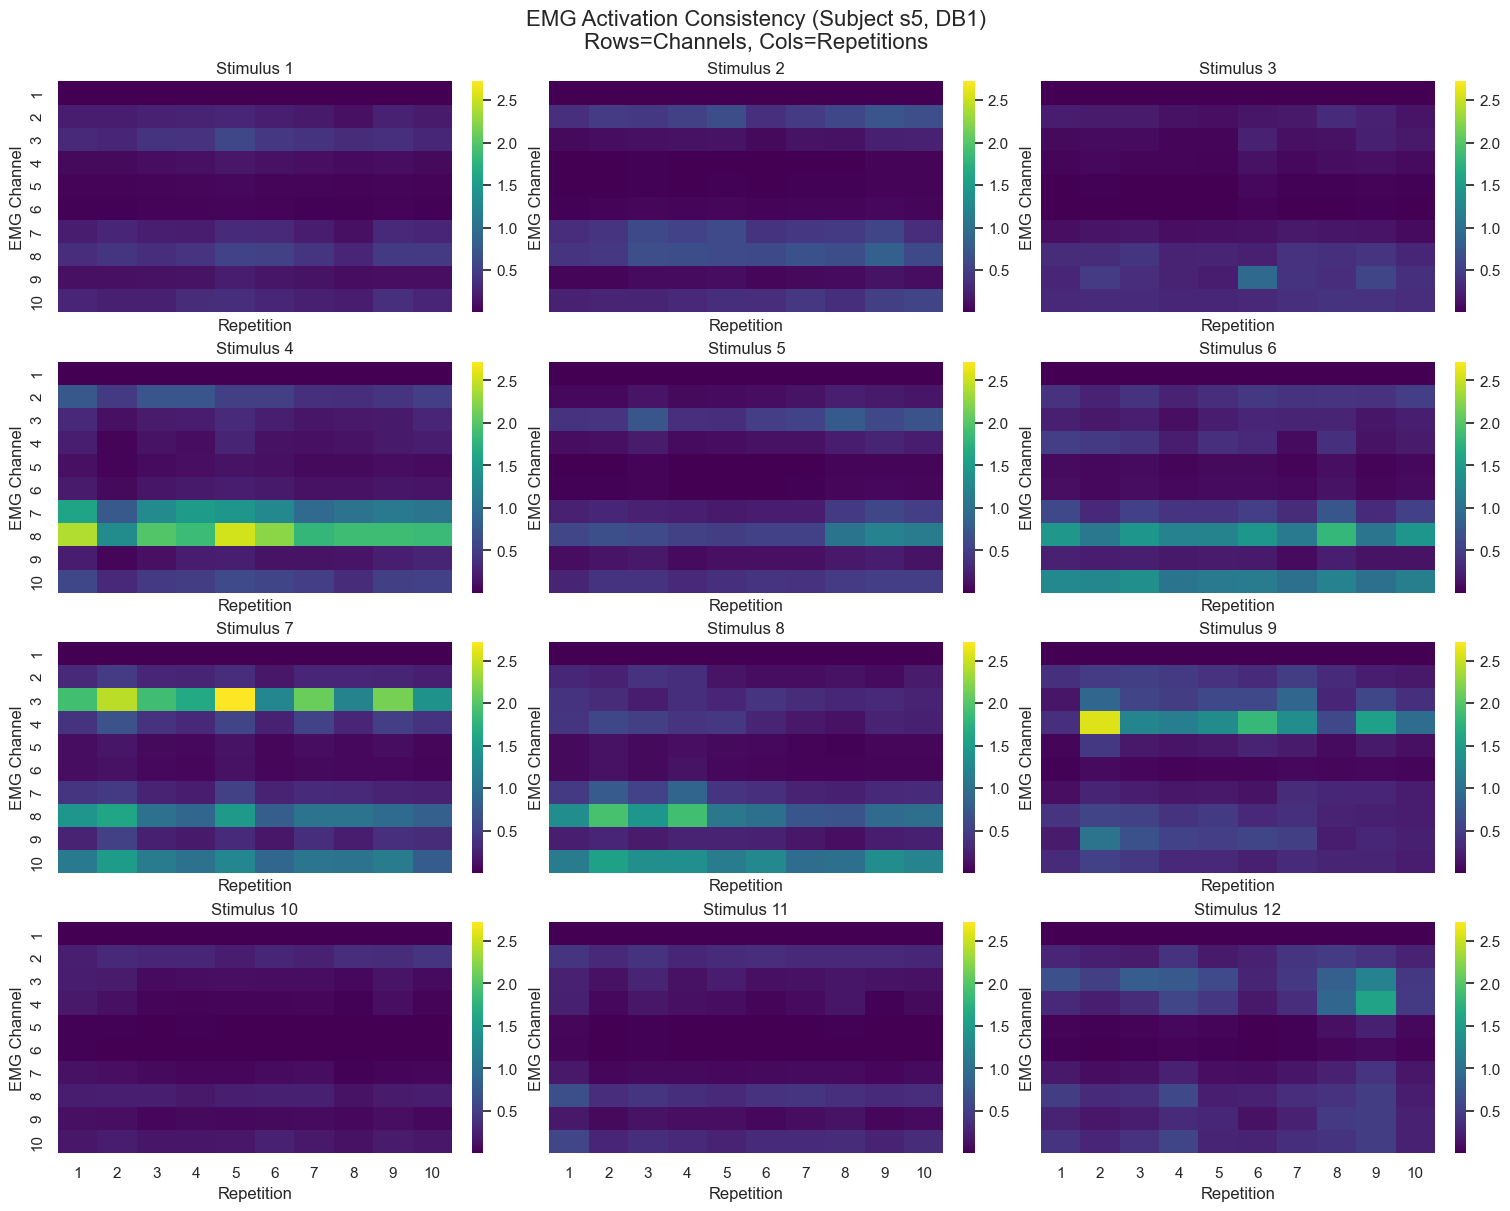

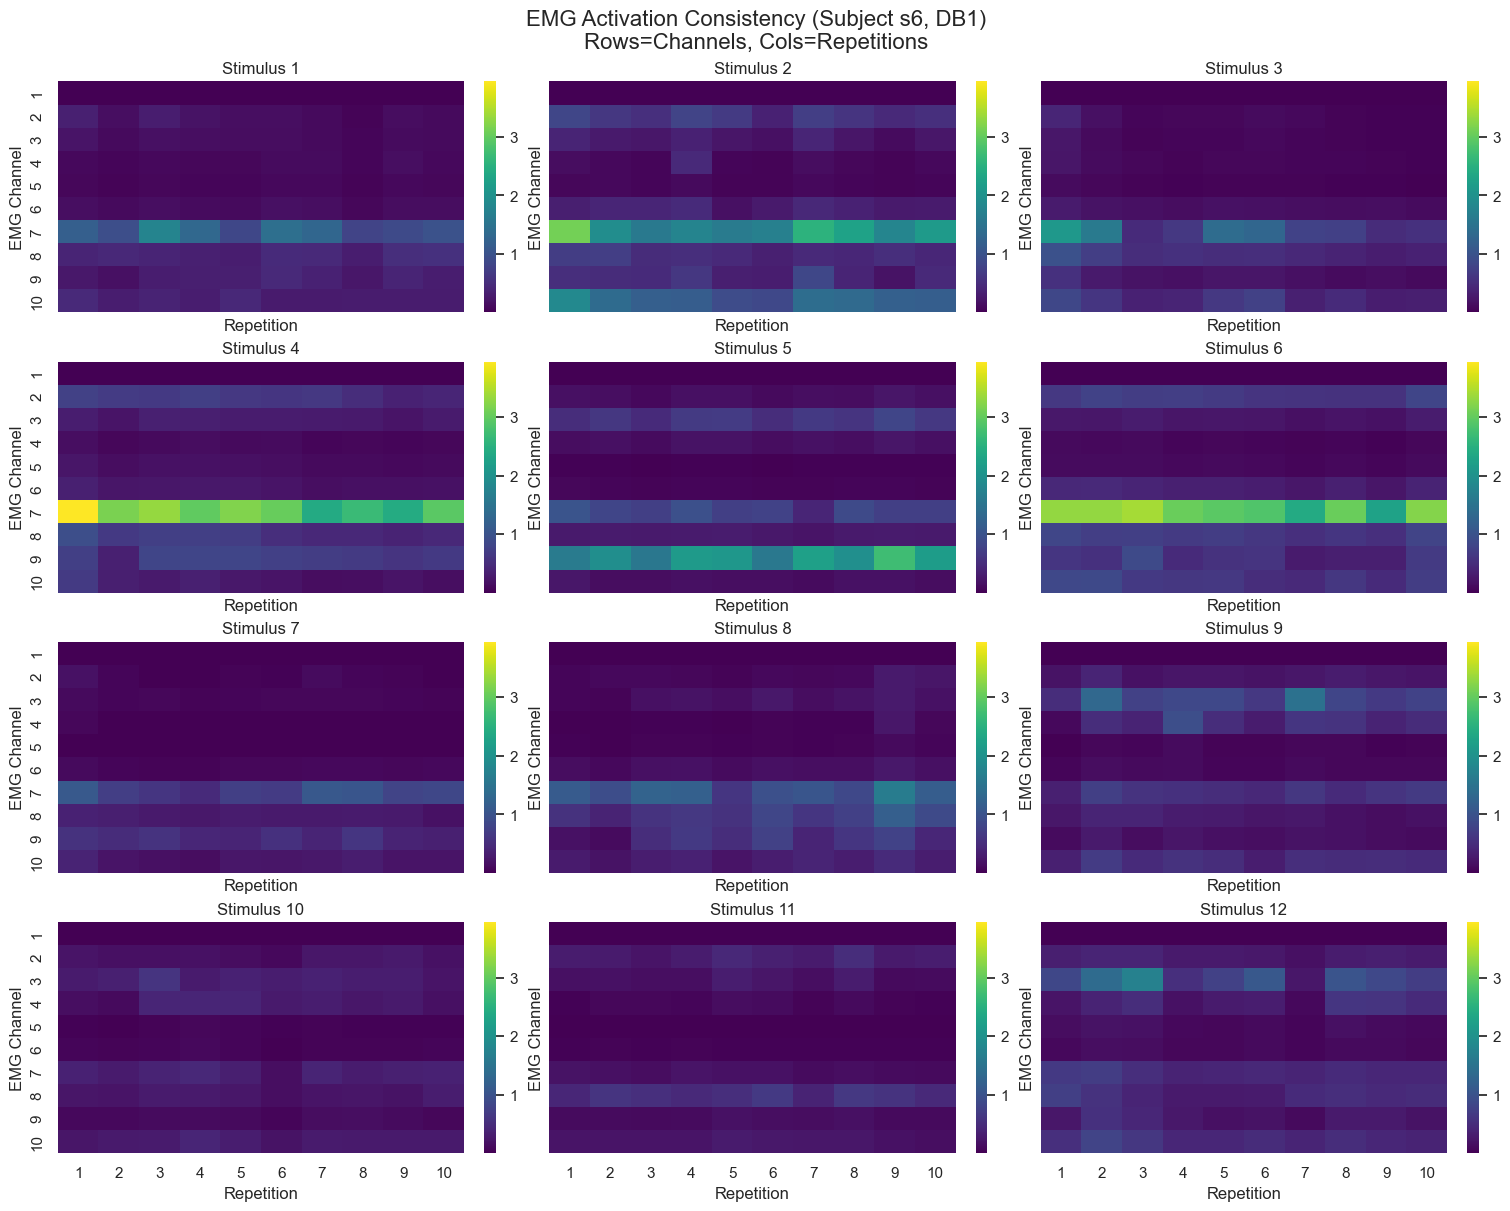

In [38]:
for jj in range (1,7):
    s_num_lowercase = 's' + str(jj)
    
    input_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_cleaned.npz')
    
    data = np.load(input_path)
    emg = data['emg']
    stimulus = data['restimulus']
    repetition = data['rerepetition']
    fs = float(data['fs'])
    
    unique_movs = np.unique(stimulus)
    unique_reps = np.unique(repetition)
    
    n_channels = emg.shape[1]
    n_stimuli = len(unique_movs)
    n_repetitions = len(unique_reps)
    
    activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)
    
    for mov_idx, mov_label in enumerate(unique_movs):
        for rep_idx, rep_label in enumerate(unique_reps):
            mask = (stimulus == mov_label) & (repetition == rep_label)
            trial_data = emg[mask]
            
            if len(trial_data) > 0:
                activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)
    
    fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    vmin = np.nanmin(activation_matrix)
    vmax = np.nanmax(activation_matrix)
    
    for stimuli_idx in range(n_stimuli):
        data_for_plot = activation_matrix[:, stimuli_idx, :]
        
        sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                    xticklabels=np.arange(1, 11), 
                    yticklabels=np.arange(1, 11), 
                    cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
        
        ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG Channel")
    
    plt.suptitle(f"EMG Activation Consistency (Subject " + s_num_lowercase + f", DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
    plt.show()